# CS 482: Optimal Path Navigation

#### **Goals** 
The visually impaired face many challenges in navigating their daily lives in familiar environments, but more importantly, unfamiliar environments. While there is some hope in assisting them with current technology, we seek to provide a more intuitive and effective solution that considers real-time environmental data to provide safer navigation. The goal for this project is to provide the technical foundation for implementing a physical prototype that can be worn by the user and will signal to them a suggested path using vibration gloves.


#### **Needed Libraries** 
- Ipykernel, Numpy, Pandas, Pillow, Matplotlib
- Transformers: provides access to pre-trained models on the HuggingFace website.
    - Install with pip: `pip install -q transformers`
    - Official Website for further reference: https://huggingface.co/transformers/v3.5.1/installation.html


#### **Testing Data Procedures**
1. Choose an environment to navigate through, such as a study room with tables.
2. Take pictures at various angles in the room so that it captures all of the visible objects in the room.
    - Tip: start at the entrance of the room and walk around, taking photos of the ground and the open space.
3. Decide which photo will be the starting point for your user. 





$$ \text{Observed Brightness}(\mathbf{x}) = \text{Albedo}(\mathbf{x})\cos(\theta_\mathbf{x}) = \text{Albedo}(\mathbf{x}) \left[ \hat{l} \cdot \hat{n}(\mathbf{x}) \right] $$

where $\hat{l}$ is the *light direction* (normalized) and $\hat{n}(\mathbf{x})$ is the *surface normal* at location $\mathbf{x}$.

For this breakout session, I have provided you with an *albedo matrix* `albedos` (of dimension $m \times n$) and the accompanying *normals* `normals` (of dimension $m \times n \times 3$, where the normal vector at coordinate `i, j` is `normals[i, j]`).

**TASK** Write a function `light_scene` that computes an $m \times n$ "lit scene" image from (1) the albedos, (2) the normals, and (3) the light directions.

I have provided you with both data and some partially-implemented functions for this process. If your `light_scene` function is implemented correctly, the `light_scene_interactive` function I have included below should instantiate an interactive widget with which you can move the light around with sliders and see the effect.

**PLOTS** Include 4 different lightings of the "bunny" scene in your writeup.

*Data and Images* from: 
- Buddah: https://courses.cs.washington.edu/courses/csep576/05wi/projects/project3/project3.htm
- Scholar: http://vision.seas.harvard.edu/qsfs/Data.html


#### **Related Experiments**
1. Raja, S., Bhatia, T., Mishra, A., Kashyap, S., & Verma, O. P. (2017). Autonomous Pathfinding in Simulated 3D           Environment. *Proceedings of the 2017 International Conference on Robotics and Artificial Intelligence*, 56–60. https://doi.org/10.1145/3175603.3175621 
    - This source aims to navigate through an environment simulated with Blender using **depth information (from a CNN)** and path planning. The neural network was trained using randomly generated images, and the path was planned using a "heuristic aided search algorithm" that uses a left and right camera to determine a short term path at every step. The algorithms were tested using the Manhattan distance and the Euclidean distance as the distance heuristics. If objects appear to be too close from the depth estimation, another path is selected until there is a step with no detected obstacles.

2. Perera, G. S. T., Madhubhashini, K. W. R., Lunugalage, D., Piyathilaka, D. V. S., Lakshani, W. H. U., & Kasthurirathna, 
D. (2021). Computer Vision Based Indoor Navigation for Shopping Complexes. *Proceedings of the 2020 4th International Conference on Vision, Image and Signal Processing*, 15, 1–6. https://doi.org/10.1145/3448823.3448828
    - The authors created an indoor navigation system that would allow the user to navigate inside shopping malls with audio instructions guiding them. First, computer vision was used to estimate their current location, where a **CNN was trained** with a dataset of the specific malls' signs with their locations on a map. Then, the phone sensors detect the orientation and speed of the user, and the A* algorithm searches for the shortest path to the destination, with audio instructions and a chatbot to lead the user there. 

3. Ivanchenko, V., Coughlan, J., Gerrey, W., & Shen, H. (2008). Computer Vision-Based Clear Path Guidance for Blind Wheelchair Users. *Proceedings of the 10th International ACM SIGACCESS Conference on Computers and Accessibility*, 291–292. https://doi.org/10.1145/1414471.1414543 
    - This article describes a prototype meant to guide blind wheelchair users through their environment. Although this source does not specifically plan the path for the user, computer vision is incorporated through the system using stereo vision to alert the user of any obstacles. The **Point Grey Bumblebee 2 stereo camera** is placed above the seat, and the **elevation of the surrounding area** allows the system to detect the obstacles (anything different from the base elevation).

4. Rahman, S., Shah, A. S., & Whitney, G. (2004). Computer Vision based navigation system for the visually impaired. *ACM SIGGRAPH 2004 Posters*, 64. https://doi.org/10.1145/1186415.1186489 
    - Despite the article only consisting of an extended abstract, the goal of this experiment was to develop a navigation system for visually impaired people based on computer vision, predominantly in outdoor environments. The two main components are "matchng key objects from image sequences and matching a pre-defined scene from the image database with image sequences." These techniques involved using various algorithms, including "gray level template matching, shape model matching, scale invariant shape model matching, and edge based shape model matching," and their future research planned to account for different lightings, heights, and objects more commonly found indoors. 

5. Sivan, S., & Darsan, G. (2016). Computer Vision based Assistive Technology For Blind and Visually Impaired People. *Proceedings of the 7th International Conference on Computing Communication and Networking Technologies*, 41, 1–8. https://doi.org/10.1145/2967878.2967923 
    - Building on related projects with devices assisting the visually impaired, a multi-purpose prototype was created with object detection, text recognition, door detection, and a security feature. The device includes multiple algorithms, specifically Histogram equalization, the Canny Edge detector, and BRISK (Binary Robust Invariant Scalable Keypoints), where images are taken and processed with a raspberry pi system managing the various functions through an input device.


In [3]:
from transformers import pipeline   # Import for Depth Estimator from HuggingFace website
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

# Creates the depth_estimator pipeline from HuggingFace
depth_estimator = pipeline(task="depth-estimation", model="LiheYoung/depth-anything-base-hf")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [4]:
from transformers import pipeline

depth_estimator = pipeline(task="depth-estimation", model="LiheYoung/depth-anything-base-hf")
output = depth_estimator("images/book.webp")

In [5]:
output = depth_estimator("http://images.cocodataset.org/val2017/000000039769.jpg")
# This is a tensor with the values being the depth expressed in meters for each pixel
output["predicted_depth"].shape
output["predicted_depth"]

tensor([[[26.3996, 26.3003, 26.3928,  ..., 24.8489, 24.9059, 20.0686],
         [26.2259, 26.2092, 26.3427,  ..., 24.8448, 24.6682, 24.6084],
         [26.0719, 26.0483, 26.1254,  ..., 24.7053, 24.6746, 24.5809],
         ...,
         [43.2635, 43.2343, 43.2892,  ..., 39.0545, 39.2171, 39.0818],
         [43.3636, 43.2703, 43.3899,  ..., 39.1390, 38.9937, 39.0318],
         [38.7509, 43.2192, 43.4387,  ..., 38.5408, 38.3691, 35.3692]]])

In [6]:
# Runs the depth estimator model: input = URL / file path
output = depth_estimator("http://images.cocodataset.org/val2017/000000039769.jpg")

# This is a tensor with the values being the depth expressed in meters for each pixel
print(output["predicted_depth"].shape)
print(output["predicted_depth"])

torch.Size([1, 518, 686])
tensor([[[26.3997, 26.3004, 26.3929,  ..., 24.8489, 24.9059, 20.0686],
         [26.2260, 26.2093, 26.3428,  ..., 24.8448, 24.6682, 24.6084],
         [26.0719, 26.0483, 26.1255,  ..., 24.7053, 24.6745, 24.5809],
         ...,
         [43.2635, 43.2343, 43.2892,  ..., 39.0545, 39.2170, 39.0818],
         [43.3636, 43.2703, 43.3899,  ..., 39.1390, 38.9937, 39.0318],
         [38.7509, 43.2192, 43.4387,  ..., 38.5408, 38.3691, 35.3692]]]), 'depth': <PIL.Image.Image image mode=L size=640x480 at 0x1CD7F9E7650>}


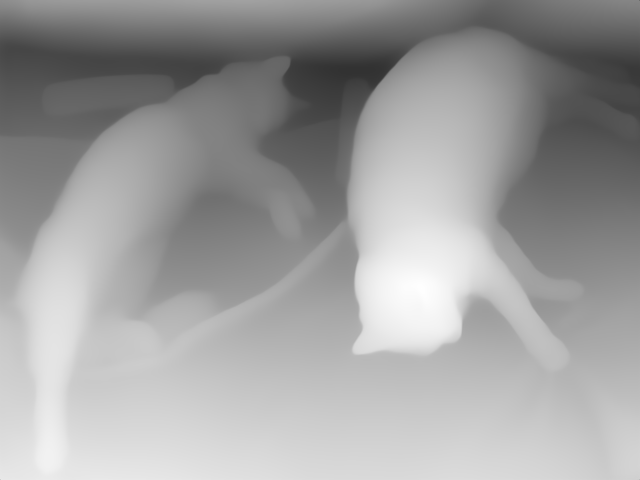

In [7]:
output["depth"]

tensor([[[17.3041, 17.3192, 17.3883,  ..., 20.4376, 20.2982, 16.5202],
         [17.2571, 17.3014, 17.4371,  ..., 20.5958, 20.4077, 20.3002],
         [17.3003, 17.3222, 17.4107,  ..., 20.6523, 20.6061, 20.4928],
         ...,
         [61.0330, 60.9246, 61.0107,  ...,  9.1666,  9.2229,  9.1900],
         [61.2090, 61.0067, 61.1375,  ...,  9.2188,  9.2647,  9.2191],
         [54.6855, 61.1370, 61.1959,  ...,  9.2592,  9.1440,  8.6043]]])


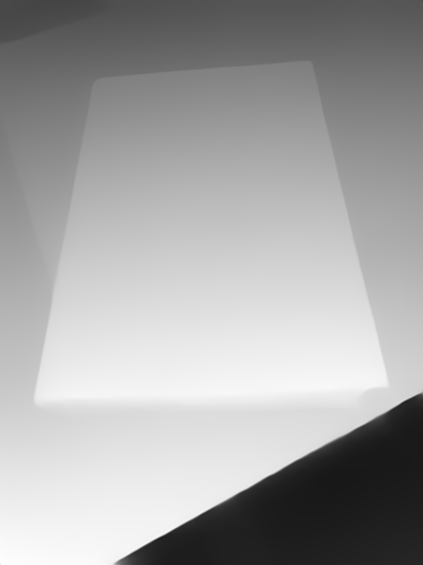

In [8]:
output = depth_estimator("images/book.webp")
# This is a tensor with the values being the depth expressed in meters for each pixel
print(output["predicted_depth"])
output["depth"]

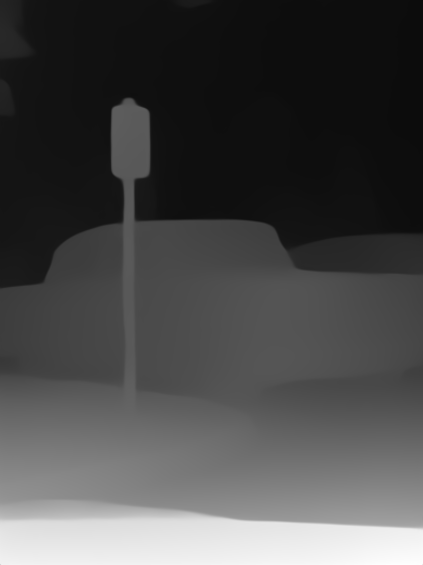

In [9]:
output = depth_estimator("images/condensed_car.webp")
# This is a tensor with the values being the depth expressed in meters for each pixel
output["depth"]

In [10]:
from transformers import pipeline
import numpy as np
import cv2

# Load the depth estimator model
depth_estimator = pipeline(task="depth-estimation", model="LiheYoung/depth-anything-base-hf")

# Estimate depth from an image
output = depth_estimator("images/mason_statue.webp")
depth_map = output["depth"]

# convert depth_map to a numpy array
depth_map = np.array(depth_map, dtype=np.float32)

# Camera parameters for iPhone 15 Pro
f_x = f_y = 2245  # Estimated focal length in pixels
c_x = 2016        # Estimated x-coordinate of the optical center
c_y = 1512        # Estimated y-coordinate of the optical center

# Prepare to generate point cloud
height, width = depth_map.shape
point_cloud = []

for i in range(height):
    for j in range(width):
        Z = depth_map[i, j]
        if Z == 0: # Ignore points with zero depth
            continue
        X = (j - c_x) * Z / f_x
        Y = (i - c_y) * Z / f_y
        point_cloud.append([X, Y, Z])

# Convert to a NumPy array
point_cloud = np.array(point_cloud)

np.savetxt('point_cloud.xyz', point_cloud)


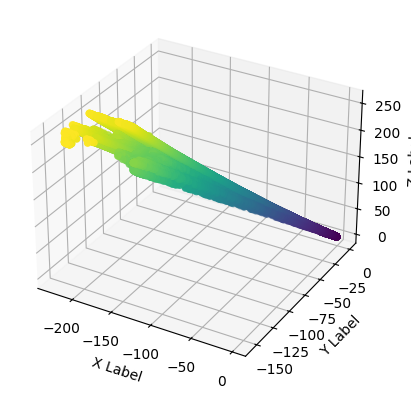

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

point_cloud = np.loadtxt('point_cloud.xyz')

# Extracting individual components
x = point_cloud[:, 0]
y = point_cloud[:, 1]
z = point_cloud[:, 2]

# Creating a new matplotlib figure and a 3D subplot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(x, y, z, c=z, cmap='viridis', marker='o')  # Coloring by height (z-coordinate)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# Showing the plot
plt.show()


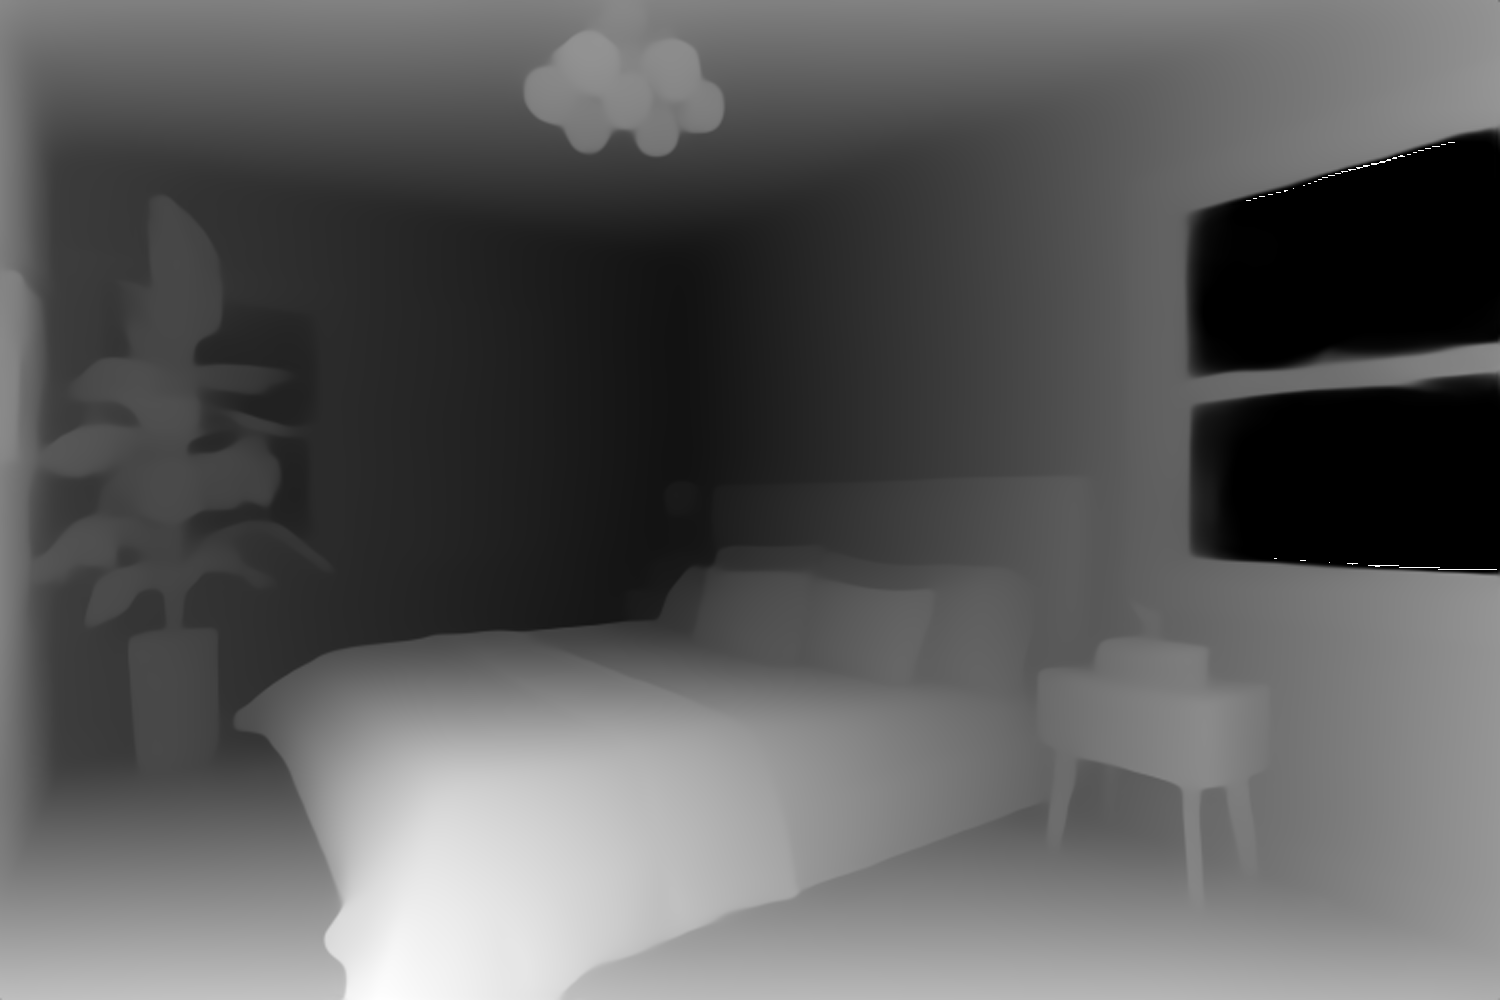

In [12]:
output = depth_estimator("images/room_in_house.jpg")
# This is a tensor with the values being the depth expressed in meters for each pixel
output["depth"]

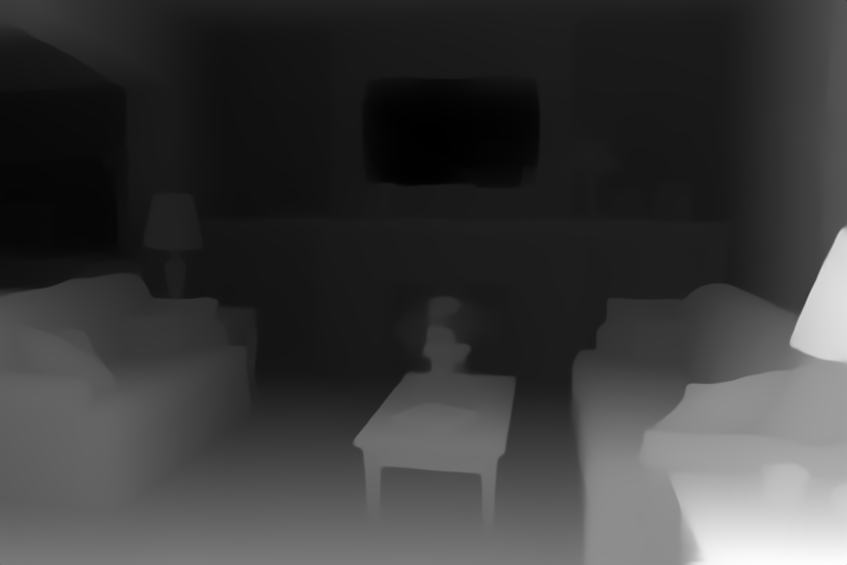

In [13]:
output = depth_estimator("images/room2.webp")
# This is a tensor with the values being the depth expressed in meters for each pixel
output["depth"]

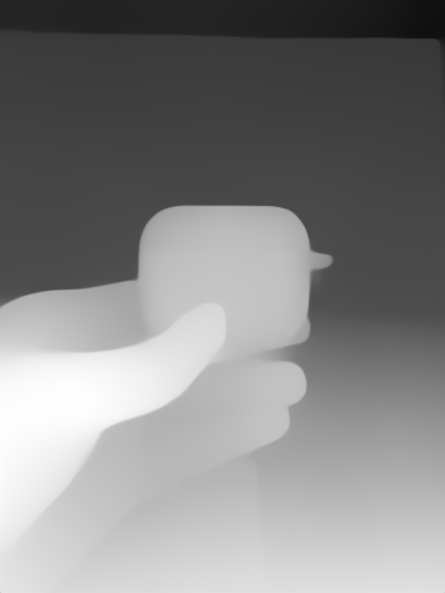

In [14]:
output = depth_estimator("images/airpods2.webp")
# This is a tensor with the values being the depth expressed in meters for each pixel
output["depth"]

In [15]:
output["predicted_depth"]

tensor([[[ 9.9957, 10.0864, 10.1932,  ...,  4.6102,  4.5134,  4.0169],
         [ 9.8364,  9.9961, 10.1638,  ...,  4.6870,  4.6506,  4.6546],
         [ 9.8860, 10.0129, 10.1111,  ...,  4.6192,  4.6728,  4.7096],
         ...,
         [62.0291, 61.9402, 61.9318,  ..., 60.3789, 60.5308, 60.5409],
         [62.1781, 61.9838, 62.0776,  ..., 60.5967, 60.6652, 60.8629],
         [55.5514, 61.9723, 62.1695,  ..., 60.6804, 61.0202, 56.6540]]])

TypeError: Invalid shape (1, 518, 392) for image data

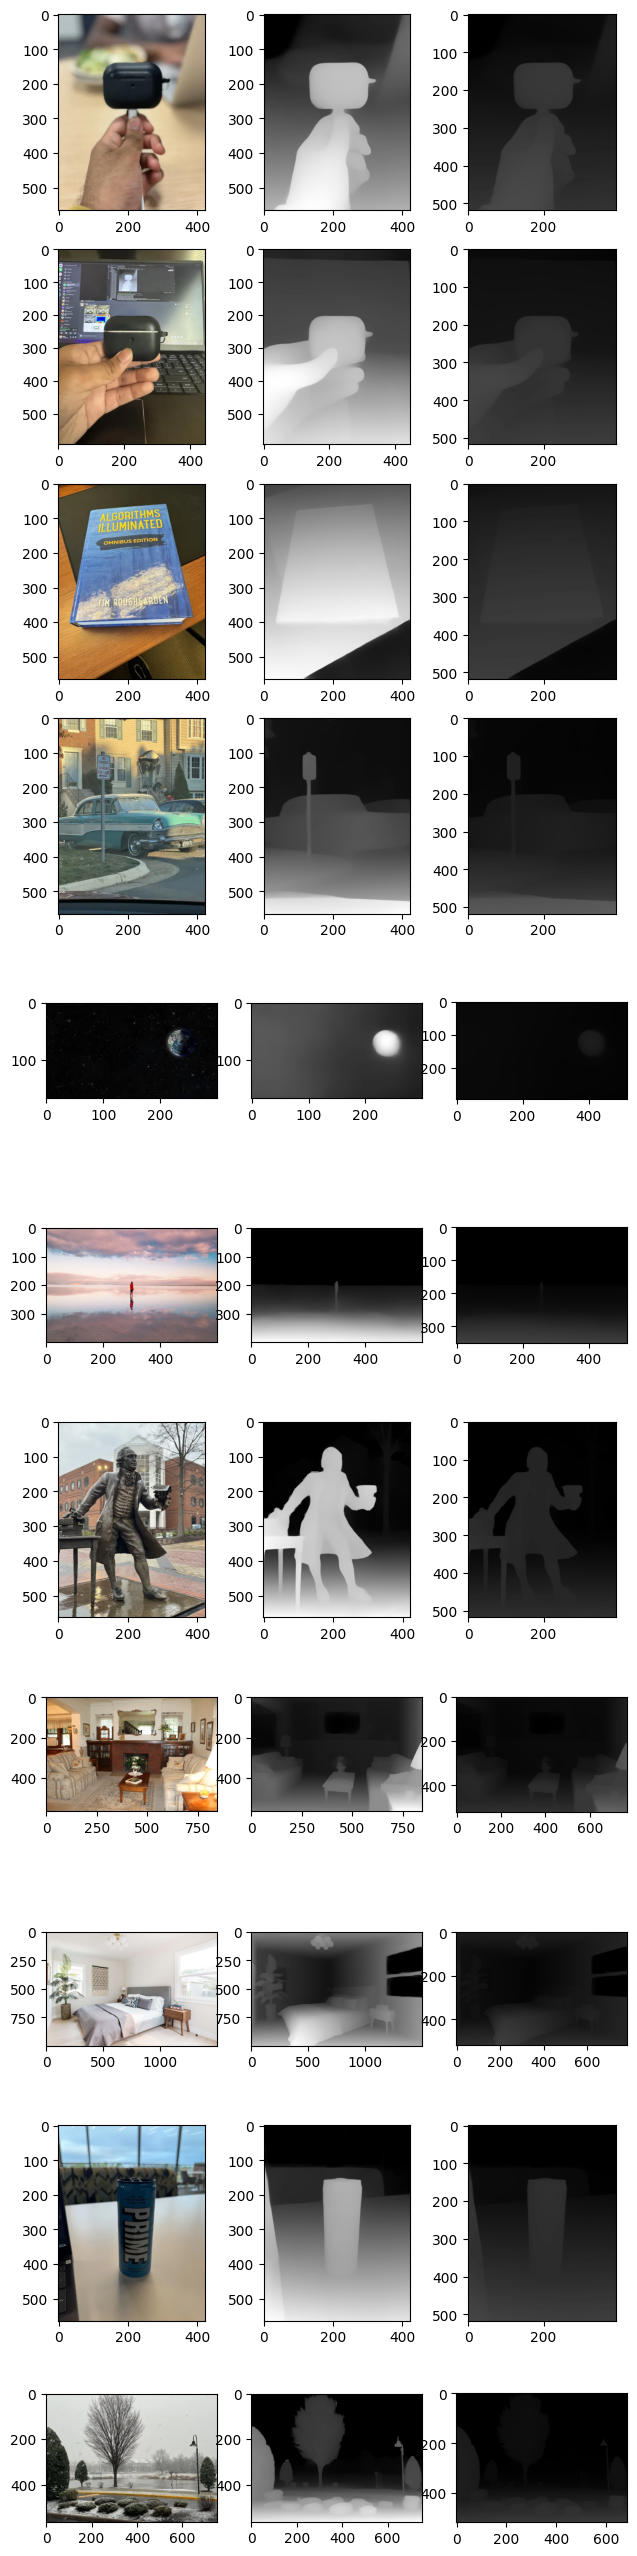

In [16]:
"""
Helper Function to display the images in a folder, their depth maps, and their predicted depths.
Displays the image inside of the function in a display_count x 3 grid and does not return any values.

Parameters
----------
depth_model: the pre-loaded depth estimator pipeline that will create the depth maps for the images

img_folder_path: the path (relative or absolute) to the image folder
    Note: do not include a final slash at the end

display_count: the number of images to be displayed
    If this argument is not given, this function will display all the images in the folder.

"""
def display_img_depths(depth_model, img_folder_path="images", display_count=None):
    if (depth_model is None):
        return
    
    grid_out = 0    # The image output after running the depth estimator
    orig_img = None # The original PIL Image  
    num_cols = 3    # The number of columns: original, depth, predicted_depth
    image_paths = os.listdir(img_folder_path)

    if (display_count == None):
        display_count = len(image_paths)

    plt.figure(figsize=(2.5 * num_cols, 3 * display_count))
    for ind, f in enumerate(image_paths):
        # Stop when the display_count is reached
        if (ind == display_count):
            break
        
        # Display the original image
        plt.subplot(display_count, num_cols, ind * num_cols + 1)
        orig_img = Image.open(f"{img_folder_path}/{f}")
        plt.imshow(orig_img)

        # Display the depth map
        plt.subplot(display_count, num_cols, ind * num_cols + 2)
        grid_out = depth_model(f"{img_folder_path}/{f}")
        plt.imshow(grid_out["depth"], cmap='gray', vmin=0, vmax=255)

        # Display the predicted depth original image
        plt.subplot(display_count, num_cols, ind * num_cols + 3)
        grid_out = depth_model(f"{img_folder_path}/{f}")
        plt.imshow(grid_out["predicted_depth"][0], cmap='gray', vmin=0, vmax=255)



display_img_depths(depth_estimator)

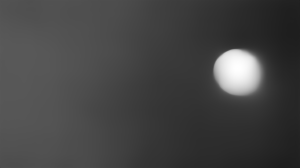

In [ ]:
output = depth_estimator("images/earth.jpg")
# This is a tensor with the values being the depth expressed in meters for each pixel
output["depth"]

In [ ]:
"""
NOTE: cannot use depth_estimator on a full video.
FIX: convert video to individual frames, run estimator on each frame, and reconvert to video
"""

# output = depth_estimator("videos/IMG_2119.mov")
# output["depth"]

'\nNOTE: cannot use depth_estimator on a full video.\nFIX: convert video to individual frames, run estimator on each frame, and reconvert to video\n'

In [ ]:
import numpy as np
depth_arr = np.asarray(output["depth"])

print(f"Depth Array Shape = {depth_arr.shape}")
print(depth_arr)
print(np.max(depth_arr))

Depth Array Shape = (565, 423)
[[  0   0   0 ...  98  95  78]
 [  0   0   0 ...  98  97  95]
 [  0   0   0 ...  98  98  98]
 ...
 [180 180 180 ... 175 175 175]
 [178 180 180 ... 175 175 174]
 [160 178 181 ... 174 173 161]]
255


The output video is videos/chipotle/frames/chipotle.mp4


'\nfor file in files:\n        print(file)\n        output = depth_estimator(directory + "/" + file)\n        # This is a tensor with the values being the depth expressed in meters for each pixel\n        output["depth"]\n        index = index + 1\n'

ModuleNotFoundError: No module named 'matplotlib'